# WordCloud Notebook

Membuat WordCloud dari kata-kata yang terdapat pada data

## Import Libraries

Import library yang akan digunakan

In [1]:
import os
import pickle
import re
import string
import unicodedata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from indoNLP.preprocessing import *
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

**Configs**

In [2]:
SEED = 2020

## Load Dataset

Load dataset hasil scraping sebelumnya

**Load Dataset**

In [3]:
data = pd.concat([
    pd.read_csv("../data/Crawling Twitter Jakarta 20 - 22.csv"),
    pd.read_csv("../data/Crawling Twitter Jakarta 23 - 25.csv"),
    pd.read_csv("../data/Crawling Twitter Jakarta 26.csv")
])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48985 entries, 0 to 5229
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tanggal   48985 non-null  object
 1   tweets    48985 non-null  object
 2   username  48985 non-null  object
 3   retweet   48985 non-null  int64 
 4   source    48985 non-null  object
 5   hashtags  48985 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.6+ MB


## Preprocessing & Predicting

Preprocessing data dan melakukan peramalan dengan menggunakan model yang sudah di train sebelumnya.

In [4]:
STEMMER = StemmerFactory().create_stemmer()
STOPWORDS.update(set(StopWordRemoverFactory().get_stop_words())) # stopwords

def preprocessing(text):
    text = text.lower()
    text = re.sub(r"\s+", " ", text, flags=re.UNICODE)  # remove whitespace
    text = emoji_to_words(text)  # remove emoji
    text = unicodedata.normalize("NFD", text).encode("ascii", "ignore").decode("ascii")
    text = remove_html(text)  # remove html tags
    text = remove_url(text)  # remove url
    text = replace_word_elongation(text)  # replace WE
    text = replace_slang(text)  # replace slang words
    text = text.translate(str.maketrans(string.digits, " " * len(string.digits)))  # remove numbers
    text = text.translate(
        str.maketrans(string.punctuation, " " * len(string.punctuation))
    )  # remove punctuation
    text = " ".join(text.split())
    text = STEMMER.stem(text)
    return " ".join(text.split())

model = pickle.load(open(f"../model/[TRAINED] Pipelined TF-IDF - SVM.pickle", "rb"))

**Run preprocessing & predicting**

In [5]:
new_data = pd.DataFrame()
new_data["cleaned"] = [preprocessing(x) for x in tqdm(data["tweets"].values)]
new_data["prediction"] = model.predict(new_data["cleaned"].values)
new_data.head()

  0%|          | 0/48985 [00:00<?, ?it/s]

,cleaned,prediction
0,nataliuspigai christwamea turut kbbi kamus bah...,1
1,saya ikut acara dari awal coba di cek recordny...,2
2,peri gigi tak akan serang covid pakar sehat da...,1
3,y vngdumb nanti ada corona lagi gimne wkw,0
4,polda metro tidak akan beri izin kepada kspi d...,1


Memisahkan index data yang bersentimen positif dan negatif

In [6]:
index_p = new_data["cleaned"][new_data["prediction"] == 2].index
index_n = new_data["cleaned"][new_data["prediction"] == 0].index

### Load Vectorizer

Transform data yang telah di preprocessing dengan TF-IDF untuk mendapatkan matix kata

In [7]:
vectorizer = TfidfVectorizer(max_features=3000)
word_mat = vectorizer.fit_transform(new_data["cleaned"].values)
word_mat

<48985x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 762236 stored elements in Compressed Sparse Row format>

**Nama Fitur**

Mengambil nama fitur / kata - kata yang terdapat pada vectorizer

In [8]:
nama_fitur = vectorizer.get_feature_names_out()

## Spesifikasi Kata Positif & Kata Negatif

Karena akan dibuat 2 WordCloud untuk kata Positif dan kata Negatif maka perlu menspesifikasikan kata Positif dan Negatif terlebih dahulu

In [9]:
positif = word_mat[index_p]
negatif = word_mat[index_n]

## Mencari Kata Positif & Kata Negatif dengan Bobot Tertinggi

Karena jumlah kata yang ada sangat banyak maka akan dipilih kata dengan bobot tertinggi saja untuk ditampilkan kedalam WordCloud.

In [10]:
def finder(words):
    top_kata = {}
    for i in range(words.shape[0]):
        row = words.getrow(i).toarray()[0]
        max_ = np.argmax(row)
        if nama_fitur[max_] in top_kata:
            top_kata[nama_fitur[max_]] += 1
        else:
            top_kata[nama_fitur[max_]] = 1
    return top_kata

top_positif = finder(positif)
top_negatif = finder(negatif)

**Sorting**

Mengurutkan kata dengan bobot tertinggi dengan frekuensi terbanyak sampai terendah

In [11]:
# Sorting
top_positif = {k: v for k, v in sorted(top_positif.items(), key=lambda item: item[1], reverse=True)}
top_negatif = {k: v for k, v in sorted(top_negatif.items(), key=lambda item: item[1], reverse=True)}

## Membuat WordCloud

Membuat WordCloud untuk kata positif dan kata negatif.

**Positif**

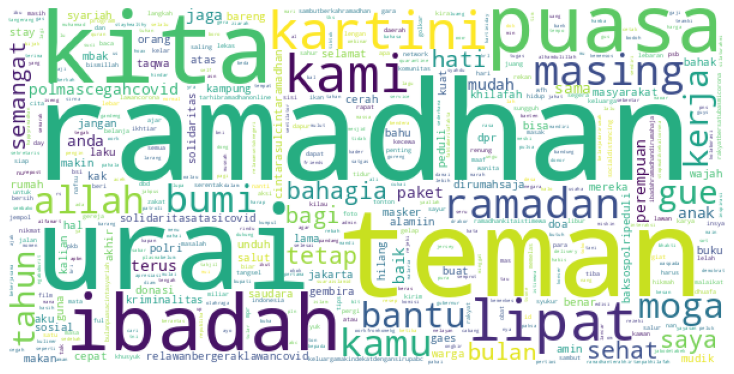

In [12]:
# WordCloud kata dengan bobot terbesar Positif
w = WordCloud(
    width=600,
    height=300,
    colormap='viridis',
    mode="RGBA",
    stopwords=STOPWORDS,
    background_color="white",
    max_words=5000,
    random_state=SEED
).fit_words(top_positif)

plt.figure(figsize=(10, 10), facecolor=None)
plt.imshow(w)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

**Negatif**

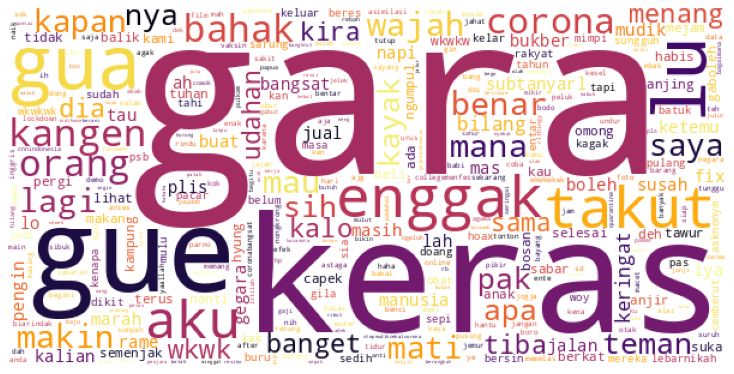

In [13]:
w = WordCloud(
    width=600,
    height=300,
    mode="RGBA",
    stopwords=STOPWORDS,
    colormap='inferno',
    background_color="white",
    max_words=5000,
).fit_words(top_negatif)

plt.figure(figsize=(10, 10), facecolor=None)
plt.imshow(w)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()